## Lab 4 - Tensorflow ANN for regression

In this lab we will use Tensorflow to build an Artificial Neuron Network (ANN) for a regression task.

As opposed to the low-level implementation from the previous week, here we will use Tensorflow to automate many of the computation tasks in the neural network. [Tensorflow](https://www.tensorflow.org/) is a higher-level open-source machine learning library [released by Google last year](https://googleblog.blogspot.com/2015/11/tensorflow-smarter-machine-learning-for.html) which is made specifically to optimize and speed up the development and training of neural networks. 

At its core, Tensorflow is very similar to numpy and other numerical computation libraries. Like numpy, it's main function is to do very fast computation on multi-dimensional datasets (such as computing the dot product between a vector of input values and a matrix of values representing the weights in a fully connected network). While numpy refers to such multi-dimensional data sets as 'arrays', Tensorflow calls them 'tensors', but fundamentally they are the same thing. The two main advantages of Tensorflow over custom low-level solutions are:

- While it has a Python interface, much of the low-level computation is implemented in C/C++, making it run much faster than a native Python solution.
- Many common aspects of neural networks such as computation of various losses and a variety of modern optimization techniques are implemented as built in methods, reducing their implementation to a single line of code. This also helps in development and testing of various solutions, as you can easily swap in and try various solutions without having to write all the code by hand.

You can get more details about various popular machine learning libraries in [this comparison](http://deeplearning4j.org/compare-dl4j-torch7-pylearn.html).

To test our basic network, we will use the [Boston Housing Dataset](https://archive.ics.uci.edu/ml/datasets/Housing), which represents data on 506 houses in Boston across 14 different features. One of the features is the median value of the house in $1000’s. This is a common data set for testing regression performance of machine learning algorithms. All 14 features are continuous values, making them easy to plug directly into a neural network (after normalizing ofcourse!). The common goal is to predict the median house value using the other columns as features.

This lab will conclude with two assignments:

- Assignment 1 (at bottom of this notebook) asks you to experiment with various regularization parameters to reduce overfitting and improve the results of the model.
- Assignment 2 (in the next notebook) asks you to take our regression problem and convert it to a classification problem.

Let's start by importing some of the libraries we will use for this tutorial:

In [7]:
%matplotlib inline
import math
import random

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_boston

import numpy as np
import tensorflow as tf

sns.set(style="ticks", color_codes=True)

Next, let's import the Boston housing prices dataset. This is included with the scikit-learn library, so we can import it directly from there. The data will come in as two numpy arrays, one with all the features, and one with the target (price). We will use pandas to convert this data to a DataFrame so we can visualize it. We will then print the first 5 entries of the dataset to see the kind of data we will be working with.

In [8]:
#load data from scikit-learn library
dataset = load_boston()

#load data as DataFrame
houses = pd.DataFrame(dataset.data, columns=dataset.feature_names)
#add target data to DataFrame
houses['target'] = dataset.target

#print first 5 entries of data
print (houses.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  target  
0     15.3  396.90   4.98    24.0  
1     17.8  396.90   9.14    21.6  
2     17.8  392.83   4.03    34.7  
3     18.7  394.63   2.94    33.4  
4     18.7  396.90   5.33    36.2  


You can see that the dataset contains only continuous features, which we can feed directly into the neural network for training. The target is also a continuous variable, so we can use regression to try to predict the exact value of the target. You can see more information about this dataset by printing the 'DESCR' object stored in the data set.

In [9]:
print (dataset['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Next, we will do some exploratory data visualization to get a general sense of the data and how the different features are related to each other and to the target we will try to predict. First, let's plot the correlations between each feature. Larger positive or negative correlation values indicate that the two features are related (large positive or negative correlation), while values closer to zero indicate that the features are not related (no correlation).

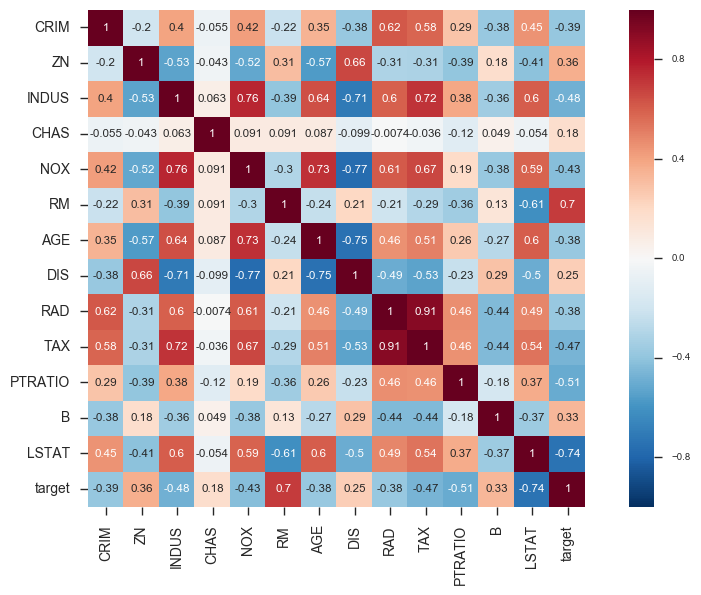

In [10]:
# Create a datset of correlations between house features
corrmat = houses.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 6))

# Draw the heatmap using seaborn
sns.set_context("notebook", font_scale=0.7, rc={"lines.linewidth": 1.5})
sns.heatmap(corrmat, annot=True, square=True)
f.tight_layout()

We can get a more detailed picture of the relationship between any two variables in the dataset by using seaborn's `jointplot` function and passing it two features of our data. This will show a single-dimension histogram distribution for each feature, as well as a two-dimension density scatter plot for how the two features are related. From the correlation matrix above, we can see that the `RM` feature has a strong positive correlation to the target, while the `LSTAT` feature has a strong negative correlation to the target. Let's create `jointplots` for both sets of features to see how they relate in more detail:

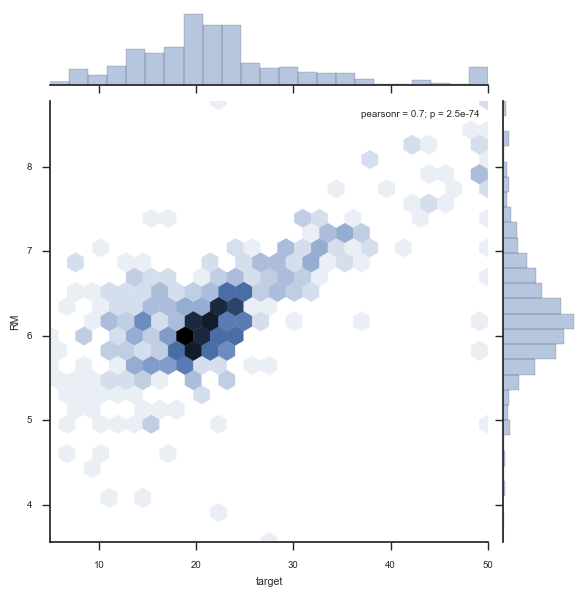

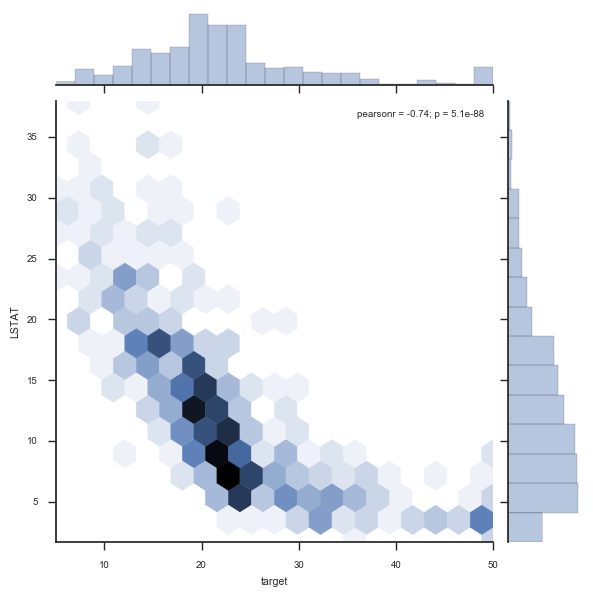

In [11]:
sns.jointplot(houses['target'], houses['RM'], kind='hex')
sns.jointplot(houses['target'], houses['LSTAT'], kind='hex')

As expected, the plots show a positive relationship between the `RM` feature and the target, and a negative relationship between the `LSTAT` feature and the target.

This type of exploratory visualization is not strictly necessary for using machine learning, but it does help to formulate your solution, and to troubleshoot your implementation incase you are not getting the results you want. For example, if you find that two features have a strong correlation with each other, you might want to include only one of them to speed up the training process. Similarly, you may want to exclude features that show little correlation to the target, since they have little influence over its value.

Now that we know a little bit about the data, let's prepare it for training with our neural network. We will follow a process similar to the previous lab:

- We will first re-split the data into a feature set (X) and a target set (y)
- Then we will normalize the feature set so that the values range from 0 to 1
- Finally, we will split both data sets into a training and test set.

In [12]:
# convert housing data to numpy format
houses_array = houses.as_matrix().astype(float)

# split data into feature and target sets
X = houses_array[:, :-1]
y = houses_array[:, -1]

# normalize the data per feature by dividing by the maximum value in each column
X = X / X.max(axis=0)

# split data into training and test sets
trainingSplit = int(.7 * houses_array.shape[0])

X_train = X[:trainingSplit]
y_train = y[:trainingSplit]
X_test = X[trainingSplit:]
y_test = y[trainingSplit:]

print(('Training set'), (X_train.shape), (y_train.shape))
print(('Test set'), (X_test.shape), (y_test.shape))

Training set (354, 13) (354,)
Test set (152, 13) (152,)


Next, we set up some variables that we will use to define our model. The first group are helper variables taken from the dataset which specify the number of samples in our training set, the number of features, and the number of outputs. The second group are the actual hyper-parameters which define how the model is structured and how it performs. In this case we will be building a neural network with two hidden layers, and the size of each hidden layer is controlled by a hyper-parameter. The other hyper-parameters include:

- `batch size`, which sets how many training samples are used at a time
- `learning rate` which controls how quickly the gradient descent algorithm works
- `training epochs` which sets how many rounds of training occurs
- `dropout keep probability`, a regularization technique which controls how many neurons are 'dropped' randomly during each training step (note in Tensorflow this is specified as the 'keep probability' from 0 to 1, with 0 representing all neurons dropped, and 1 representing all neurons kept). You can read more about dropout [here](http://neuralnetworksanddeeplearning.com/chap3.html#other_techniques_for_regularization).

In [13]:
# helper variables
num_samples = X_train.shape[0]
num_features = X_train.shape[1]
num_outputs = 1

# Hyper-parameters
batch_size = 50
num_hidden_1 = 16
num_hidden_2 = 16
learning_rate = 0.0001
training_epochs = 200
dropout_keep_prob = 1.0 # set to no dropout by default

# variable to control the resolution at which the training results are stored
display_step = 1

Next, we define a few helper functions which will dictate how error will be measured for our model, and how the weights and biases should be defined.

The `accuracy()` function defines how we want to measure error in a regression problem. The function will take in two lists of values - `predictions` which represent predicted values, and `targets` which represent actual target values. In this case we simply compute the absolute difference between the two (the error) and return the average error using numpy's `mean()` fucntion.

The `weight_variable()` and `bias_variable()` functions help create parameter variables for our neural network model, formatted in the proper type for Tensorflow. Both functions take in a shape parameter and return a variable of that shape using the specified initialization. In this case we are using a 'truncated normal' distribution for the weights, and a constant value for the bias. For more information about various ways to initialize parameters in Tensorflow you can consult the [documentation](https://www.tensorflow.org/versions/r0.11/api_docs/python/constant_op.html)

In [14]:
def accuracy(predictions, targets):
    error = np.absolute(predictions.reshape(-1) - targets)
    return np.mean(error)

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

Now we are ready to build our neural network model in Tensorflow.

Tensorflow operates in a slightly different way than the procedural logic we have been using in Python so far. Instead of telling Tensorflow the exact operations to run line by line, we build the entire neural network within a structure called a `Graph`. The Graph does several things:

- describes the architecture of the network, including how many layers it has and how many neurons are in each layer
- initializes all the parameters of the network
- describes the 'forward' calculation of the network, or how input data is passed through the network layer by layer until it reaches the result
- defines the loss function which describes how well the model is performing
- specifies the optimization function which dictates how the parameters are tuned in order to minimize the loss

Once this graph is defined, we can work with it by 'executing' it on sets of training data and 'calling' different parts of the graph to get back results. Every time the graph is executed, Tensorflow will only do the minimum calculations necessary to generate the requested results. This makes Tensorflow very efficient, and allows us to structure very complex models while only testing and using certain portions at a time. In programming language theory, this type of programming is called ['lazy evaluation'](https://en.wikipedia.org/wiki/Lazy_evaluation).

In [15]:
'''First we create a variable to store our graph'''
graph = tf.Graph()

'''Next we build our neural network within this graph variable'''
with graph.as_default():
    
    '''Our training data will come in as x feature data and 
    y target data. We need to create tensorflow placeholders 
    to capture this data as it comes in'''
    
    x = tf.placeholder(tf.float32, shape=(None, num_features))
    _y = tf.placeholder(tf.float32, shape=(None))
    
    '''Another placeholder stores the hyperparameter 
    that controls dropout'''
    
    keep_prob = tf.placeholder(tf.float32)
    
    '''Finally, we convert the test and train feature data sets 
    to tensorflow constants so we can use them to generate 
    predictions on both data sets'''
    
    tf_X_test = tf.constant(X_test, dtype=tf.float32)
    tf_X_train = tf.constant(X_train, dtype=tf.float32)
    
    '''Next we create the parameter variables for the model.
    Each layer of the neural network needs it's own weight 
    and bias variables which will be tuned during training.
    The sizes of the parameter variables are determined by 
    the number of neurons in each layer.'''
    
    W_fc1 = weight_variable([num_features, num_hidden_1])
    b_fc1 = bias_variable([num_hidden_1])
    
    W_fc2 = weight_variable([num_hidden_1, num_hidden_2])
    b_fc2 = bias_variable([num_hidden_2])
    
    W_fc3 = weight_variable([num_hidden_2, num_outputs])
    b_fc3 = bias_variable([num_outputs])
    
    '''Next, we define the forward computation of the model.
    We do this by defining a function model() which takes in 
    a set of input data, and performs computations through 
    the network until it generates the output.'''
    
    def model(data, keep):
        
        # computing first hidden layer from input, using relu activation function
        fc1 = tf.nn.sigmoid(tf.matmul(data, W_fc1) + b_fc1)
        # adding dropout to first hidden layer
        fc1_drop = tf.nn.dropout(fc1, keep)
        
        # computing second hidden layer from first hidden layer, using relu activation function
        fc2 = tf.nn.sigmoid(tf.matmul(fc1_drop, W_fc2) + b_fc2)
        # adding dropout to second hidden layer
        fc2_drop = tf.nn.dropout(fc2, keep)
        
        # computing output layer from second hidden layer
        # the output is a single neuron which is directly interpreted as the prediction of the target value
        fc3 = tf.matmul(fc2_drop, W_fc3) + b_fc3
        
        # the output is returned from the function
        return fc3
    
    '''Next we define a few calls to the model() function which 
    will return predictions for the current batch input data (x),
    as well as the entire test and train feature set'''
    
    prediction = model(x, keep_prob)
    test_prediction = model(tf_X_test, 1.0)
    train_prediction = model(tf_X_train, 1.0)
    
    '''Finally, we define the loss and optimization functions 
    which control how the model is trained.
    
    For the loss we will use the basic mean square error (MSE) function,
    which tries to minimize the MSE between the predicted values and the 
    real values (_y) of the input dataset.
    
    For the optimization function we will use basic Gradient Descent (SGD)
    which will minimize the loss using the specified learning rate.'''
    
    loss = tf.reduce_mean(tf.square(tf.sub(prediction, _y)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    '''We also create a saver variable which will allow us to 
    save our trained model for later use'''
    
    saver = tf.train.Saver()

Now that we have specified our model, we are ready to train it. We do this by iteratively calling the model, with each call representing one training step. At each step, we:

- Feed in a new set of training data. Remember that with SGD we only have to feed in a small set of data at a time. The size of each batch of training data is determined by the 'batch_size' hyper-parameter specified above.

- Call the optimizer function by asking tensorflow to return the model's 'optimizer' variable. This starts a chain reaction in Tensorflow that executes all the computation necessary to train the model. The optimizer function itself will compute the gradients in the model and modify the weight and bias parameters in a way that minimizes the overall loss. Because it needs this loss to compute the gradients, it will also trigger the loss function, which will in turn trigger the model to compute predictions based on the input data. This sort of chain reaction is at the root of the 'lazy evaluation' model used by Tensorflow.

In [16]:
# create an array to store the results of the optimization at each epoch
results = []

'''First we open a session of Tensorflow using our graph as the base. 
While this session is active all the parameter values will be stored, 
and each step of training will be using the same model.'''
with tf.Session(graph=graph) as session:
    
    '''After we start a new session we first need to
    initialize the values of all the variables.'''
    tf.initialize_all_variables().run()
    print('Initialized')

    '''Now we iterate through each training epoch based on the hyper-parameter set above.
    Each epoch represents a single pass through all the training data.
    The total number of training steps is determined by the number of epochs and 
    the size of mini-batches relative to the size of the entire training set.'''
    for epoch in range(training_epochs):
        
        '''At the beginning of each epoch, we create a set of shuffled indexes 
        so that we are using the training data in a different order each time'''
        indexes = range(num_samples)
        random.shuffle(indexes)
        
        '''Next we step through each mini-batch in the training set'''
        for step in range(int(math.floor(num_samples/float(batch_size)))):
            offset = step * batch_size
            
            '''We subset the feature and target training sets to create each mini-batch'''
            batch_data = X_train[indexes[offset:(offset + batch_size)]]
            batch_labels = y_train[indexes[offset:(offset + batch_size)]]

            '''Then, we create a 'feed dictionary' that will feed this data, 
            along with any other hyper-parameters such as the dropout probability,
            to the model'''
            feed_dict = {x : batch_data, _y : batch_labels, keep_prob: dropout_keep_prob}
            
            '''Finally, we call the session's run() function, which will feed in 
            the current training data, and execute portions of the graph as necessary 
            to return the data we ask for.
            
            The first argument of the run() function is a list specifying the 
            model variables we want it to compute and return from the function. 
            The most important is 'optimizer' which triggers all calculations necessary 
            to perform one training step. We also include 'loss' and 'prediction' 
            because we want these as ouputs from the function so we can keep 
            track of the training process.
            
            The second argument specifies the feed dictionary that contains 
            all the data we want to pass into the model at each training step.'''
            _, l, p = session.run([optimizer, loss, prediction], feed_dict=feed_dict)

        '''At the end of each epoch, we will calcule the error of predictions 
        on the full training and test data set. We will then store the epoch number, 
        along with the mini-batch, training, and test accuracies to the 'results' array 
        so we can visualize the training process later. How often we save the data to 
        this array is specified by the display_step variable created above''' 
        if (epoch % display_step == 0):
            batch_acc = accuracy(p, batch_labels)
            train_acc =  accuracy(train_prediction.eval(session=session), y_train)
            test_acc =  accuracy(test_prediction.eval(session=session), y_test)
            results.append([epoch, batch_acc, train_acc, test_acc])

    '''Once training is complete, we will save the trained model so that we can use it later'''
    save_path = saver.save(session, "model_houses.ckpt")
    print("Model saved in file: %s" % save_path)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized


TypeError: 'range' object does not support item assignment

Now that the model is trained, let's visualize the training process by plotting the error we achieved in the small training batch, the full training set, and the test set at each epoch. We will also print out the minimum loss we were able to achieve in the test set over all the training steps.

In [ ]:
df = pd.DataFrame(data=results, columns = ["epoch", "batch_acc", "train_acc", "test_acc"])
df.set_index("epoch", drop=True, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
 
ax.plot(df)
ax.set(xlabel='Epoch',
       ylabel='Error',
       title='Training result')
 
ax.legend(df.columns, loc=1)

print ("Minimum test loss:"), (np.min(df["test_acc"]))

From the plot you can see several things:

- the error on the training data smoothly improves throughout the training, which is to be expected from the gradient descent algorithm
- the error of each mini-batch is more noisy than the entire training set (which is also to be expected since we are only using a portion of the data each time) but in general follows the same trajectory
- the error over the training set bottoms out around the 120th epoch, which might represent the best model fit for this dataset

All of this is to be expected, however the most important thing to notice with this plot is the error over the test set (which is actually measuring the generalized performance of the model). You can see that for the first 35 or so epochs the error over the test set improves in pace with the error over the training set. This means that the tuning of the model is fitting the underlying structures in both datasets. However, after the 70th epoch, the error over the test starts to move back up. This is a very common indication that overfitting of the training set has occured. After this point, further tuning of the model is representing particular features of the training set itself (such as it's particular error or noise), which do not generalize well to other data not seen by the training process. This shows why it is so important to use a separate testing set to evaluate a model, since otherwise it would be impossible to see exactly where this point of overfitting occurs.

### Assignment - part 1

There are several common strategies for addressing overfitting which we will cover in class and are also covered [here](http://neuralnetworksanddeeplearning.com/chap3.html). Go back to the neural network and experiment with different settings for some of the hyper-parameters to see if you can fix this 'double-dip' in the test set error. One approach might be to reduce the number of layers in the network or the number of neurons in each layer, since a simpler model is less likely to overfit. Another approach might be to increase the amount of dropout, since this will artificially limit the complexity of the model.

_Bonus:_ there is one fundamental issue with how I'm using the data from the very beginning which is also contributing to the overfitting problem in this particular case. Can you think of something we can do to the data before training which would ensure that the training and test sets are more similar?

Once you fix the overfitting problem and achieve a minimum test loss of less than 6.0, submit your work as a pull request back to the main project.

In [ ]:
%matplotlib inline
import math
import random

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_boston

import numpy as np
import tensorflow as tf

sns.set(style="ticks", color_codes=True)

In [ ]:
%matplotlib inline
import math
import random

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_boston

import numpy as np
import tensorflow as tf

sns.set(style="ticks", color_codes=True)

In [ ]:
print (dataset['DESCR'])

In [ ]:
# Create a datset of correlations between house features
corrmat = houses.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 6))

# Draw the heatmap using seaborn
sns.set_context("notebook", font_scale=0.7, rc={"lines.linewidth": 1.5})
sns.heatmap(corrmat, annot=True, square=True)
f.tight_layout()

In [ ]:
sns.jointplot(houses['target'], houses['RM'], kind='hex')
sns.jointplot(houses['target'], houses['LSTAT'], kind='hex')

In [ ]:
# convert housing data to numpy format
houses_array = houses.as_matrix().astype(float)

# split data into feature and target sets
X = houses_array[:, :-1]
y = houses_array[:, -1]

# normalize the data per feature by dividing by the maximum value in each column
X = X / X.max(axis=0)

# split data into training and test sets
trainingSplit = int(.7 * houses_array.shape[0])

X_train = X[:trainingSplit]
y_train = y[:trainingSplit]
X_test = X[trainingSplit:]
y_test = y[trainingSplit:]

print(('Training set'), (X_train.shape), (y_train.shape))
print(()'Test set'), (X_test.shape), (y_test.shape))

In [ ]:
# helper variables
num_samples = X_train.shape[0]
num_features = X_train.shape[1]
num_outputs = 1

# Hyper-parameters
batch_size = 50
num_hidden_1 = 8
num_hidden_2 = 8
learning_rate = 0.0001
training_epochs = 150
dropout_keep_prob = 0.5 # set to no dropout by default

# variable to control the resolution at which the training results are stored
display_step = 1

In [ ]:
def accuracy(predictions, targets):
    error = np.absolute(predictions.reshape(-1) - targets)
    return np.mean(error)

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [ ]:
'''First we create a variable to store our graph'''
graph = tf.Graph()

'''Next we build our neural network within this graph variable'''
with graph.as_default():
    
    '''Our training data will come in as x feature data and 
    y target data. We need to create tensorflow placeholders 
    to capture this data as it comes in'''
    
    x = tf.placeholder(tf.float32, shape=(None, num_features))
    _y = tf.placeholder(tf.float32, shape=(None))
    
    '''Another placeholder stores the hyperparameter 
    that controls dropout'''
    
    keep_prob = tf.placeholder(tf.float32)
    
    '''Finally, we convert the test and train feature data sets 
    to tensorflow constants so we can use them to generate 
    predictions on both data sets'''
    
    tf_X_test = tf.constant(X_test, dtype=tf.float32)
    tf_X_train = tf.constant(X_train, dtype=tf.float32)
    
    '''Next we create the parameter variables for the model.
    Each layer of the neural network needs it's own weight 
    and bias variables which will be tuned during training.
    The sizes of the parameter variables are determined by 
    the number of neurons in each layer.'''
    
    W_fc1 = weight_variable([num_features, num_hidden_1])
    b_fc1 = bias_variable([num_hidden_1])
    
    W_fc2 = weight_variable([num_hidden_1, num_hidden_2])
    b_fc2 = bias_variable([num_hidden_2])
    
    W_fc3 = weight_variable([num_hidden_2, num_outputs])
    b_fc3 = bias_variable([num_outputs])
    
    '''Next, we define the forward computation of the model.
    We do this by defining a function model() which takes in 
    a set of input data, and performs computations through 
    the network until it generates the output.'''
    
    def model(data, keep):
        
        # computing first hidden layer from input, using relu activation function
        fc1 = tf.nn.sigmoid(tf.matmul(data, W_fc1) + b_fc1)
        # adding dropout to first hidden layer
        fc1_drop = tf.nn.dropout(fc1, keep)
        
        # computing second hidden layer from first hidden layer, using relu activation function
        fc2 = tf.nn.sigmoid(tf.matmul(fc1_drop, W_fc2) + b_fc2)
        # adding dropout to second hidden layer
        fc2_drop = tf.nn.dropout(fc2, keep)
        
        # computing output layer from second hidden layer
        # the output is a single neuron which is directly interpreted as the prediction of the target value
        fc3 = tf.matmul(fc2_drop, W_fc3) + b_fc3
        
        # the output is returned from the function
        return fc3
    
    '''Next we define a few calls to the model() function which 
    will return predictions for the current batch input data (x),
    as well as the entire test and train feature set'''
    
    prediction = model(x, keep_prob)
    test_prediction = model(tf_X_test, 1.0)
    train_prediction = model(tf_X_train, 1.0)
    
    '''Finally, we define the loss and optimization functions 
    which control how the model is trained.
    
    For the loss we will use the basic mean square error (MSE) function,
    which tries to minimize the MSE between the predicted values and the 
    real values (_y) of the input dataset.
    
    For the optimization function we will use basic Gradient Descent (SGD)
    which will minimize the loss using the specified learning rate.'''
    
    loss = tf.reduce_mean(tf.square(tf.sub(prediction, _y)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    '''We also create a saver variable which will allow us to 
    save our trained model for later use'''
    
    saver = tf.train.Saver()

In [ ]:
# create an array to store the results of the optimization at each epoch
results = []

'''First we open a session of Tensorflow using our graph as the base. 
While this session is active all the parameter values will be stored, 
and each step of training will be using the same model.'''
with tf.Session(graph=graph) as session:
    
    '''After we start a new session we first need to
    initialize the values of all the variables.'''
    tf.initialize_all_variables().run()
    print('Initialized')

    '''Now we iterate through each training epoch based on the hyper-parameter set above.
    Each epoch represents a single pass through all the training data.
    The total number of training steps is determined by the number of epochs and 
    the size of mini-batches relative to the size of the entire training set.'''
    for epoch in range(training_epochs):
        
        '''At the beginning of each epoch, we create a set of shuffled indexes 
        so that we are using the training data in a different order each time'''
        indexes = range(num_samples)
        random.shuffle(indexes)
        
        '''Next we step through each mini-batch in the training set'''
        for step in range(int(math.floor(num_samples/float(batch_size)))):
            offset = step * batch_size
            
            '''We subset the feature and target training sets to create each mini-batch'''
            batch_data = X_train[indexes[offset:(offset + batch_size)]]
            batch_labels = y_train[indexes[offset:(offset + batch_size)]]

            '''Then, we create a 'feed dictionary' that will feed this data, 
            along with any other hyper-parameters such as the dropout probability,
            to the model'''
            feed_dict = {x : batch_data, _y : batch_labels, keep_prob: dropout_keep_prob}
            
            '''Finally, we call the session's run() function, which will feed in 
            the current training data, and execute portions of the graph as necessary 
            to return the data we ask for.
            
            The first argument of the run() function is a list specifying the 
            model variables we want it to compute and return from the function. 
            The most important is 'optimizer' which triggers all calculations necessary 
            to perform one training step. We also include 'loss' and 'prediction' 
            because we want these as ouputs from the function so we can keep 
            track of the training process.
            
            The second argument specifies the feed dictionary that contains 
            all the data we want to pass into the model at each training step.'''
            _, l, p = session.run([optimizer, loss, prediction], feed_dict=feed_dict)

        '''At the end of each epoch, we will calcule the error of predictions 
        on the full training and test data set. We will then store the epoch number, 
        along with the mini-batch, training, and test accuracies to the 'results' array 
        so we can visualize the training process later. How often we save the data to 
        this array is specified by the display_step variable created above''' 
        if (epoch % display_step == 0):
            batch_acc = accuracy(p, batch_labels)
            train_acc =  accuracy(train_prediction.eval(session=session), y_train)
            test_acc =  accuracy(test_prediction.eval(session=session), y_test)
            results.append([epoch, batch_acc, train_acc, test_acc])

    '''Once training is complete, we will save the trained model so that we can use it later'''
    save_path = saver.save(session, "model_houses.ckpt")
    print("Model saved in file: %s" % save_path)

In [ ]:
df = pd.DataFrame(data=results, columns = ["epoch", "batch_acc", "train_acc", "test_acc"])
df.set_index("epoch", drop=True, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
 
ax.plot(df)
ax.set(xlabel='Epoch',
       ylabel='Error',
       title='Training result')
 
ax.legend(df.columns, loc=1)

print ("Minimum test loss:"), (np.min(df["test_acc"]))